# Unzio dataset

In [ ]:
!unzip -q "/content/drive/MyDrive/U-NET/DATASETS/Sanhaitech/part_A.zip" -d /content/

## Import Libraries

In [ ]:
import os
import cv2
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from scipy.io import loadmat
from skimage.draw import disk

import tensorflow as tf
from tensorflow.keras import layers, models


## Define path

In [ ]:
train_img_dir = "/content/part_A/train_data/images"
train_gt_dir = "/content/part_A/train_data/ground-truth"
test_img_dir = "/content/part_A/test_data/images"
test_gt_dir = "/content/part_A/test_data/ground-truth"

density_map_dir = "/content/density_maps"
os.makedirs(density_map_dir, exist_ok=True)


## Density map generator

In [ ]:
def generate_density_map(image, points, sigma=4):
    h, w = image.shape[:2]
    density = np.zeros((h, w), dtype=np.float32)
    for point in points:
        x = min(int(point[0]), w - 1)
        y = min(int(point[1]), h - 1)
        rr, cc = disk((y, x), sigma, shape=density.shape)
        density[rr, cc] += 1
    return density


## Generate and Save Normalized Density Maps

In [ ]:
train_imgs = sorted(glob(os.path.join(train_img_dir, "*.jpg")))

for img_path in tqdm(train_imgs):
    fname = os.path.basename(img_path).replace(".jpg", "")
    gt_path = os.path.join(train_gt_dir, f"GT_{fname}.mat")
    mat = loadmat(gt_path)
    points = mat["image_info"][0][0][0][0][0]

    image = cv2.imread(img_path)
    density = generate_density_map(image, points)

    np.save(os.path.join(density_map_dir, f"{fname}.npy"), density)


100%|██████████| 300/300 [00:18<00:00, 15.93it/s]


## Data Generator

In [ ]:
class CrowdDataset(tf.keras.utils.Sequence):
    def __init__(self, image_paths, density_paths, batch_size=4, input_size=(224, 224)):
        self.image_paths = image_paths
        self.density_paths = density_paths
        self.batch_size = batch_size
        self.input_size = input_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        X = []
        Y = []
        for i in range(self.batch_size):
            index = idx * self.batch_size + i
            image = cv2.imread(self.image_paths[index])
            image = cv2.resize(image, self.input_size)
            image = image.astype(np.float32) / 255.0

            fname = os.path.basename(self.image_paths[index]).replace(".jpg", "")
            density = np.load(self.density_paths[index])
            density = cv2.resize(density, self.input_size)
            density = density.astype(np.float32)
            density *= (np.sum(density) / (np.sum(density) + 1e-6))  # Preserve total count

            X.append(image)
            Y.append(density[..., np.newaxis])
        return np.array(X), np.array(Y)


## Define MCNN model

In [ ]:
def mcnn(input_shape=(224, 224, 3)):
    def column_block(filters, kernel_size):
        return models.Sequential([
            layers.Conv2D(filters, kernel_size, activation='relu', padding='same'),
            layers.Conv2D(filters, kernel_size, activation='relu', padding='same'),
            layers.MaxPooling2D()
        ])

    inputs = layers.Input(shape=input_shape)

    # Three columns with different receptive fields
    col1 = column_block(16, 9)(inputs)
    col2 = column_block(20, 7)(inputs)
    col3 = column_block(24, 5)(inputs)

    merged = layers.concatenate([col1, col2, col3])
    x = layers.Conv2D(1, 1, activation='linear', padding='same')(merged)

    # Add an upsampling layer to match the input size
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)


    model = models.Model(inputs=inputs, outputs=x)
    return model

## Load Data

In [ ]:
train_images = sorted(glob(os.path.join(train_img_dir, "*.jpg")))
train_density = sorted(glob(os.path.join(density_map_dir, "*.npy")))

train_gen = CrowdDataset(train_images, train_density, batch_size=4)


## Compile and Train

In [ ]:
model = mcnn()
model.compile(optimizer='adam', loss='mse')
model.fit(train_gen, epochs=30)
model.save("mcnn_crowd_model.h5")


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 0.0831
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0523
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0505
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0462
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0474
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0515
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0507
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0446
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0435
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0480
Epoch 11/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0457
Epoch 12/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0544
Epoch 13/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0481
Epoch 14/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0476
Epoch 15/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0493
Epoch 16/30
75

## Evaluate MAE and RMSE

In [ ]:
test_images = sorted(glob(os.path.join(test_img_dir, "*.jpg")))
test_gt = sorted(glob(os.path.join(test_gt_dir, "*.mat")))

mae = 0
mse = 0
for i in tqdm(range(len(test_images))):
    image = cv2.imread(test_images[i])
    image_resized = cv2.resize(image, (224, 224)).astype(np.float32) / 255.0

    mat = loadmat(test_gt[i])
    points = mat["image_info"][0][0][0][0][0]
    gt_count = len(points)

    pred_density = model.predict(np.expand_dims(image_resized, axis=0))[0, ..., 0]
    pred_count = np.sum(pred_density)

    mae += abs(gt_count - pred_count)
    mse += (gt_count - pred_count) ** 2

mae /= len(test_images)
mse = np.sqrt(mse / len(test_images))
print(f"MAE: {mae:.2f}, RMSE: {mse:.2f}")


  0%|          | 0/182 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step


  1%|          | 1/182 [00:01<04:00,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 3/182 [00:01<01:14,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  3%|▎         | 5/182 [00:01<00:42,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  4%|▍         | 7/182 [00:01<00:30,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  5%|▍         | 9/182 [00:01<00:23,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  6%|▌         | 11/182 [00:02<00:20,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 13/182 [00:02<00:18,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 15/182 [00:02<00:16, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  9%|▉         | 17/182 [00:02<00:15, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 10%|█         | 19/182 [00:02<00:16, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 12%|█▏        | 21/182 [00:03<00:15, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█▎        | 23/182 [00:03<00:16,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 14%|█▎        | 25/182 [00:03<00:14, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▍        | 27/182 [00:03<00:13, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 16%|█▌        | 29/182 [00:03<00:13, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 17%|█▋        | 31/182 [00:03<00:13, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|█▊        | 33/182 [00:04<00:13, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▉        | 35/182 [00:04<00:14, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|██        | 37/182 [00:04<00:13, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██▏       | 39/182 [00:04<00:13, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 41/182 [00:04<00:13, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▎       | 43/182 [00:05<00:13,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▍       | 45/182 [00:05<00:12, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 47/182 [00:05<00:13, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 49/182 [00:05<00:13,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 28%|██▊       | 51/182 [00:05<00:12, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 53/182 [00:06<00:12,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 30%|███       | 55/182 [00:06<00:13,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 56/182 [00:06<00:13,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 31%|███▏      | 57/182 [00:06<00:13,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 32%|███▏      | 59/182 [00:06<00:11, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▎      | 61/182 [00:06<00:11, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▍      | 63/182 [00:07<00:11, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▌      | 65/182 [00:07<00:11, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 67/182 [00:07<00:10, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 69/182 [00:07<00:10, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 39%|███▉      | 71/182 [00:07<00:10, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|████      | 73/182 [00:08<00:09, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 41%|████      | 75/182 [00:08<00:10, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 77/182 [00:08<00:09, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 79/182 [00:08<00:09, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▍     | 81/182 [00:08<00:09, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▌     | 83/182 [00:08<00:08, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 85/182 [00:09<00:09, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 87/182 [00:09<00:08, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 89/182 [00:09<00:08, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|█████     | 91/182 [00:09<00:08, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|█████     | 93/182 [00:09<00:09,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 52%|█████▏    | 95/182 [00:10<00:10,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|█████▎    | 96/182 [00:10<00:10,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|█████▎    | 97/182 [00:10<00:10,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 54%|█████▍    | 99/182 [00:10<00:10,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 55%|█████▍    | 100/182 [00:10<00:09,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 55%|█████▌    | 101/182 [00:10<00:10,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▌    | 102/182 [00:11<00:10,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|█████▋    | 103/182 [00:11<00:10,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 57%|█████▋    | 104/182 [00:11<00:11,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|█████▊    | 105/182 [00:11<00:11,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 58%|█████▊    | 106/182 [00:11<00:10,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|█████▉    | 107/182 [00:11<00:10,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▉    | 108/182 [00:12<00:10,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|█████▉    | 109/182 [00:12<00:10,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 60%|██████    | 110/182 [00:12<00:09,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 61%|██████    | 111/182 [00:12<00:09,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 62%|██████▏   | 112/182 [00:12<00:09,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 62%|██████▏   | 113/182 [00:12<00:09,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 115/182 [00:12<00:07,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▎   | 116/182 [00:12<00:07,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▍   | 118/182 [00:13<00:06,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 119/182 [00:13<00:06,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 120/182 [00:13<00:06,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 67%|██████▋   | 122/182 [00:13<00:06,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████▊   | 123/182 [00:13<00:06,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████▊   | 124/182 [00:13<00:06,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 69%|██████▉   | 126/182 [00:14<00:06,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 70%|██████▉   | 127/182 [00:14<00:06,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|███████   | 128/182 [00:14<00:06,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████   | 129/182 [00:14<00:06,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████▏  | 130/182 [00:14<00:06,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▏  | 131/182 [00:14<00:06,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 73%|███████▎  | 132/182 [00:14<00:06,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 73%|███████▎  | 133/182 [00:14<00:06,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▍  | 135/182 [00:15<00:05,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▍  | 136/182 [00:15<00:05,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|███████▌  | 137/182 [00:15<00:05,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|███████▌  | 138/182 [00:15<00:05,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|███████▋  | 139/182 [00:15<00:05,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|███████▋  | 141/182 [00:15<00:04,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 78%|███████▊  | 142/182 [00:16<00:04,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 79%|███████▊  | 143/182 [00:16<00:04,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 79%|███████▉  | 144/182 [00:16<00:04,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|███████▉  | 145/182 [00:16<00:04,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 80%|████████  | 146/182 [00:16<00:04,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 81%|████████  | 147/182 [00:16<00:04,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 149/182 [00:16<00:03,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 151/182 [00:17<00:03,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▎ | 152/182 [00:17<00:03,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 153/182 [00:17<00:03,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 85%|████████▌ | 155/182 [00:17<00:02, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|████████▋ | 157/182 [00:17<00:02, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 159/182 [00:17<00:02,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 161/182 [00:18<00:02, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|████████▉ | 163/182 [00:18<00:01, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████ | 165/182 [00:18<00:01, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 167/182 [00:18<00:01, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 169/182 [00:18<00:01, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▍| 171/182 [00:18<00:00, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 95%|█████████▌| 173/182 [00:19<00:00, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 96%|█████████▌| 175/182 [00:19<00:00, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 97%|█████████▋| 177/182 [00:19<00:00, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 98%|█████████▊| 179/182 [00:19<00:00, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 99%|█████████▉| 181/182 [00:19<00:00,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


100%|██████████| 182/182 [00:19<00:00,  9.13it/s]

MAE: 2134.49, RMSE: 2283.92


## Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


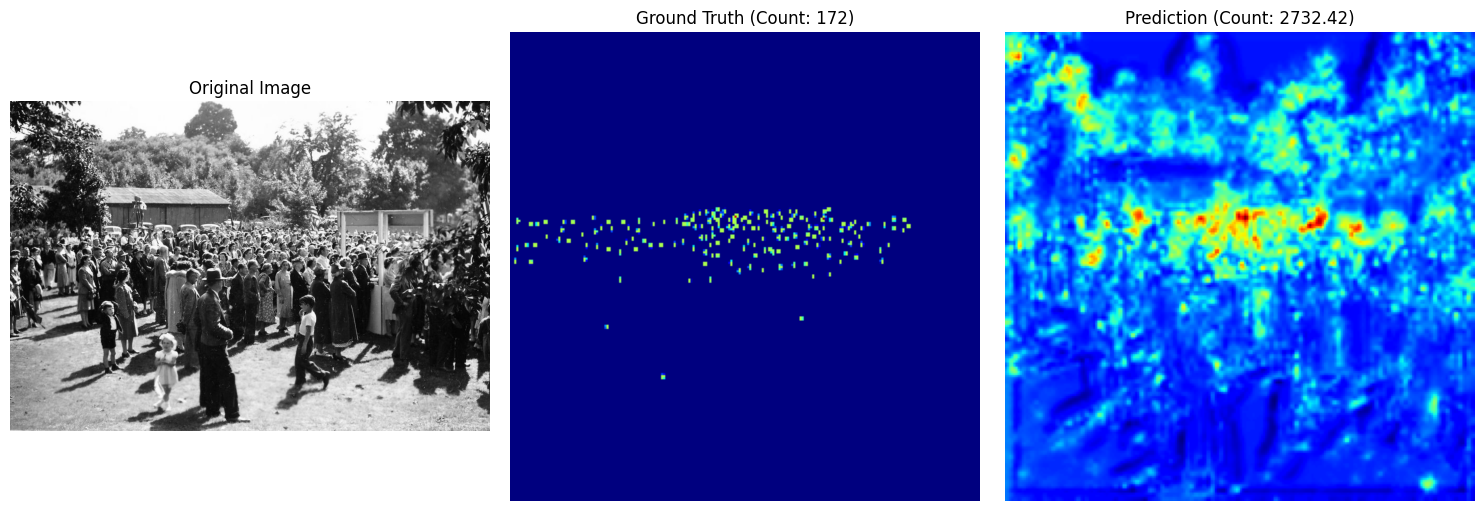

In [ ]:
def visualize_result(image_path, mat_path, model, input_size=(224, 224)):
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, input_size).astype(np.float32) / 255.0

    mat = loadmat(mat_path)
    points = mat["image_info"][0][0][0][0][0]
    gt_density = generate_density_map(image, points)
    gt_resized = cv2.resize(gt_density, input_size)

    pred_density = model.predict(np.expand_dims(image_resized, axis=0))[0, ..., 0]
    pred_count = np.sum(pred_density)
    gt_count = len(points)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_resized, cmap='jet')
    plt.title(f"Ground Truth (Count: {gt_count})")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_density, cmap='jet')
    plt.title(f"Prediction (Count: {pred_count:.2f})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
visualize_result(test_images[0], test_gt[0], model)